In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from __future__ import print_function

Populating the interactive namespace from numpy and matplotlib


In [2]:
#load the saved pickle file for converting apars to obs coords
with open('/home/nil/Dropbox/streamgap-pepper/pal5_64sampling.pkl','rb') as savefile:
            sdf_smooth= pickle.load(savefile)
            sdf_pepper= pickle.load(savefile)



In [13]:
def convert_dens_apar_to_dens_xi(apars,dens,dens_smooth,mO,poly_deg=2):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens_contrast(xi)-normalized by polynomial fit)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    xi=mxieta[:,0]
    
    #We want to find d(xi)d(apar) at the apars that's in the output file.
    #Treating those apars and xi as the mid-point of the apar and xi bins, compute the 
    #their edges. Bin widths are not uniform, so a few more lines of code. For the 
    #first and last edge, use the first and last bin width.
    
    apar_edge=[]
    xi_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    xibw0=xi[1]-xi[0]
    xi_edge.append(xi[0]-(xibw0/2.))


    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        xibw=xi[ii+1]-xi[ii]
        apar_edge.append(apars[ii]+abw/2.)
        xi_edge.append(xi[ii]+xibw/2.)

    
    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    xibw_last=xi[len(xi)-1]-xi[len(xi)-2]
    xi_edge.append(xi[len(xi)-1]+(xibw_last/2.))
    
    #compute d(xi)/d(apar) using finite difference method
    dxi_dapar=(numpy.diff(xi_edge)/numpy.diff(apar_edge))
    
    #Interpolate Jacobian
    ipdxi_dapar=interpolate.InterpolatedUnivariateSpline(apars,dxi_dapar)

    outxi= numpy.arange(0.25,14.35,0.1)
    # Interpolate xi and apar
    ipxi= interpolate.InterpolatedUnivariateSpline(xi,apars)
    
    #dens(xi) = dens(apars)*d(xi)/d(apars)
    dens_xi=dens*ipdxi_dapar(apars)
    dens_smooth_xi=dens_smooth*ipdxi_dapar(apars)
    
    ipdens_xi= interpolate.InterpolatedUnivariateSpline(apars,dens_xi) #note only dens
    ipdens_smooth_xi= interpolate.InterpolatedUnivariateSpline(apars,dens_smooth_xi)
    
    pp= Polynomial.fit(xi,ipdens_xi(ipxi(xi)),deg=poly_deg)
    
    return (outxi,ipdens_xi(ipxi(outxi)),ipdens_smooth_xi(ipxi(outxi)),pp(outxi))



def convert_dens_to_obs(apars,dens,dens_smooth,mO):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))
    

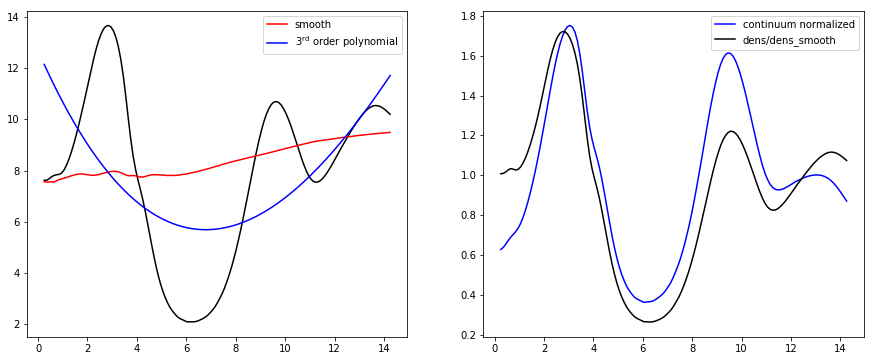

In [16]:
bfilename= '/home/nil/Dropbox/streamgap-pepper/streamdata/pal5_multtime/fromJo/'
dens_filename='pal5_t64sampling_X10_6-9_dens.dat'
omega_filename= dens_filename.replace('dens','omega')

dens_a= np.genfromtxt(bfilename + dens_filename,delimiter=',',max_rows=5002)
omega_a=np.genfromtxt(bfilename + omega_filename,delimiter=',',max_rows=5002)

from random import randint
#sim_ind=randint(2, len(dens_a)-1)
#print sim_ind
sim_ind=25 #20
apars=dens_a[0]
dens_unp=dens_a[1]
omega=omega_a[sim_ind]
dens=dens_a[sim_ind]


xi,densxi,densxi_smooth,ppdens=convert_dens_apar_to_dens_xi(apars,dens,dens_unp,omega,poly_deg=3)

xi1,dens_con= convert_dens_to_obs(apars,dens,dens_unp,omega)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(xi,densxi,c='k')
plt.plot(xi,densxi_smooth,c='r',label='smooth')


plt.plot(xi,ppdens,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.legend(loc='upper right')
plt.subplot(1,2,2)

plt.plot(xi,densxi/ppdens,c='b',label='continuum normalized')
plt.plot(xi1,dens_con,c='k',label='dens/dens_smooth')
plt.legend(loc='upper right')


plt.show()